---
title: Normalizing Flows
author: Mark Fuge
date: 'October 19 2025'
format:
    html:
        code-fold: true
        code-summary: "Show Code"
---

In the previous chapter we trained a Variational Autoencoder (VAE) to learn a latent representation that could reconstruct and generate samples. VAEs rely on a probabilistic encoder-decoder pair and optimize the Evidence Lower Bound (ELBO). In this notebook we take a different perspective: we build models that exactly transform a simple base distribution (e.g., a Gaussian) into our target data distribution using a sequence of invertible mappings known as *normalizing flows*.

We will reuse the same 2D ring-of-Gaussians dataset that we have been using in prior notebooks so far, so that we can compare models directly and focus on the geometric intuition behind these transformations.

## Learning Objectives

- Understand how normalizing flows differ from VAEs in the way they model probability densities
- Apply the change-of-variables formula to relate base and transformed distributions
- Experiment with invertible transformations in 1D and 2D to build intuition
- Implement and train a RealNVP-style normalizing flow on the ring dataset
- Summarize the advantages and limitations of flows and motivate continuous or stochastic extensions

In [1]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Normal
from dataclasses import dataclass
from typing import List, Tuple

try:
    from ipywidgets import interact, FloatSlider, IntSlider
    widgets_available = True
except Exception:
    interact = None
    FloatSlider = IntSlider = None
    widgets_available = False

from gen_models_utilities import (
    device,
    create_ring_gaussians,
    make_loader,
    compute_diversity_metric
)

plt.style.use('seaborn-v0_8-muted')
sns.set_context('talk')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f'Using device: {device}')

Using device: cuda


## VAEs vs. Normalizing Flows

VAEs *approximate* the data likelihood by maximizing an evidence lower bound, balancing a reconstruction term with a KL regularizer on the latent posterior. Normalizing flows instead learn an *exactly* normalizable density by composing invertible transformations that map a simple base distribution to the target data distribution using the change-of-variables formula.

The key trade-off is between tractable posterior inference (VAE) and exact likelihood modeling with potentially sharper samples (flow). Both rely on simple base distributions, but flows *must* ensure every transformation remains invertible with a tractable Jacobian determinant.

## Key Idea: The Change-of-Variables Formula

Suppose we want to transform a simple base random variable $z$ with known density $p_Z(z)$ into a new variable $x = f(z)$. If $f$ is invertible and differentiable, then the density of $x$ is given by the Change-of-Variables formula:

$$
p_X(x) = p_Z(f^{-1}(x)) \left\lvert \det \frac{\partial f^{-1}(x)}{\partial x} \right\rvert = p_Z(z) \left\lvert \det \frac{\partial f(z)}{\partial z} \right\rvert^{-1}.
$$

This formula is for a single function $f$. In Normalizing Flows, the idea is to instead construct $f$ as a **composition** of many simple, easily invertible transformations, each of which can be computed using the Change-of-Variables formula above. If we can do this, then computing the log-density reduces to **summing** the log-determinants of the Jacobians of those transformations. Let's ground this idea in an accessible one-dimensional example before moving to higher dimensions.

Specifically, we will consider first a simple tanh-based transformation, which is both invertible and differentiable. The forward function $f$ and its inverse $f^{-1}$ are given by:
$$
f(z) = \tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}, \quad f^{-1}(x) = \tanh^{-1}(x) = \frac{1}{2} \ln\left(\frac{1+x}{1-x}\right).
$$

Let's see what this transformation does to a simple base distribution, such as a standard normal.

In [2]:
#| code-fold: false
# 1D change-of-variables example with a tanh transform
num_samples = 10_000
base_normal = Normal(loc=torch.tensor(0.0, device=device), scale=torch.tensor(1.0, device=device))

# We can compute all of the below functions analytically for a given simple transformation:
def forward_transform(u: torch.Tensor) -> torch.Tensor:
    """Smooth, monotonic transform mapping R -> (-1, 1)."""
    return torch.tanh(u)

def inverse_transform(y: torch.Tensor) -> torch.Tensor:
    clipped = torch.clamp(y, min=-0.999_999, max=0.999_999)
    return 0.5 * torch.log((1 + clipped) / (1 - clipped))

def log_abs_det_jacobian(y: torch.Tensor) -> torch.Tensor:
    return -torch.log1p(-y.pow(2))

with torch.no_grad():
    z_samples = base_normal.sample((num_samples,))
    x_samples = forward_transform(z_samples)
    x_grid = torch.linspace(-0.999, 0.999, 500, device=device)
    z_grid = inverse_transform(x_grid)
    log_px = base_normal.log_prob(z_grid) + log_abs_det_jacobian(x_grid)

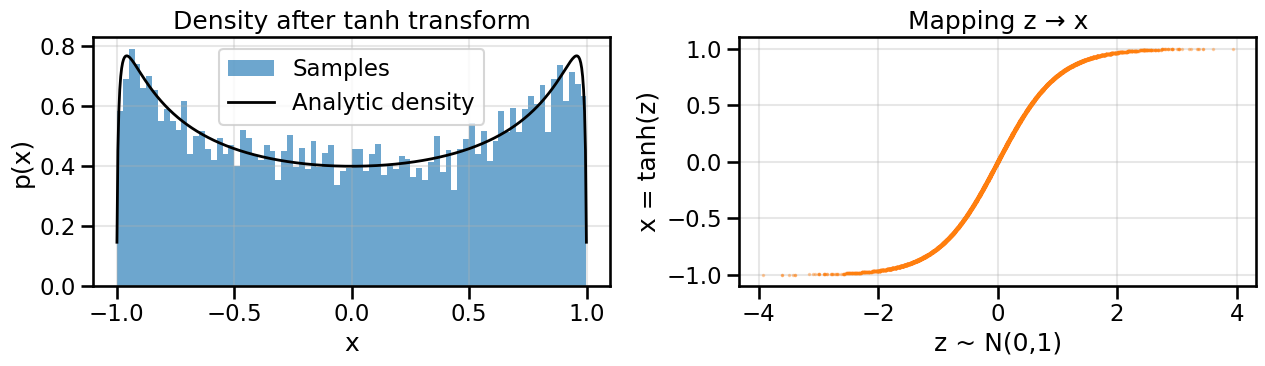

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
axes[0].hist(x_samples.cpu().numpy(), bins=80, density=True, alpha=0.65, color='tab:blue', label='Samples')
axes[0].plot(x_grid.cpu().numpy(), torch.exp(log_px).cpu().numpy(), color='black', linewidth=2, label='Analytic density')
axes[0].set_title('Density after tanh transform')
axes[0].set_xlabel('x')
axes[0].set_ylabel('p(x)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(z_samples.cpu().numpy(), x_samples.cpu().numpy(), '.', alpha=0.3, markersize=3, color='tab:orange')
axes[1].set_title('Mapping z → x')
axes[1].set_xlabel('z ~ N(0,1)')
axes[1].set_ylabel('x = tanh(z)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In this simple transformation, we can see how it modifies the density of a standard normal distribution, and also how the tranformation is invertible, since we can go both ways. We can draw a sample from $z$ and pass it through the forward transformation to get $x$, and we can also take a value of $x$ and map it back to $z$ using the inverse transformation. We can see from the mapping that the transformation is indeed invertible.

### Building Intuition Through Simple Transforms

Before we move onto more complex normalizing flows, it will help us to build geometric intuition for individual transformations. We will:

- Look at several common 1D functions that appear in flow architectures to understand how they bend the real line.
- Apply those transforms to a base Gaussian and inspect how the probability density changes.
- Explore higher-dimensional analogues (rotations, couplings, planar flows) to see how they reshape contours while keeping the transformation invertible.

Keep the change-of-variables formula in mind: steep regions of a transform squeeze probability mass, while flat regions stretch it.

In [4]:
#| code-fold: false
# Visualizing common 1D flow transformations before touching the density
import torch.nn.functional as F

z_plot = torch.linspace(-3.0, 3.0, 400, device=device)

transform_fns = {
    "Identity": lambda z: z,
    "Affine (scale=2.5, shift=1)": lambda z: 2.5 * z + 1.0,
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "Leaky ReLU (α=0.1)": lambda z: torch.where(z >= 0, z, 0.1 * z),
    "Softplus shift": lambda z: F.softplus(z) - np.log(2.0),
}

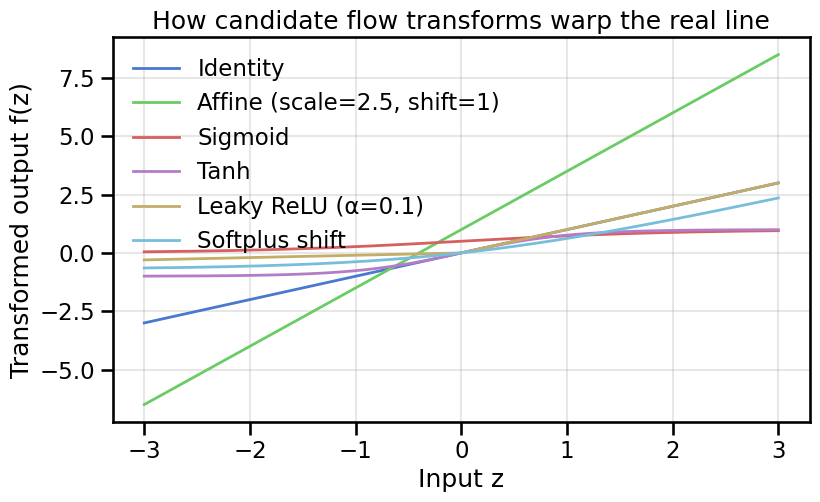

In [5]:
fig, ax = plt.subplots(figsize=(9, 5))
for label, fn in transform_fns.items():
    ax.plot(z_plot.cpu().numpy(), fn(z_plot).cpu().numpy(), linewidth=2, label=label)
ax.set_title('How candidate flow transforms warp the real line')
ax.set_xlabel('Input z')
ax.set_ylabel('Transformed output f(z)')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', frameon=False)
plt.show()

Note how in the above all warpings are monotonic functions, ensuring invertibility. Now let's see how they modify a simple Gaussian base density.

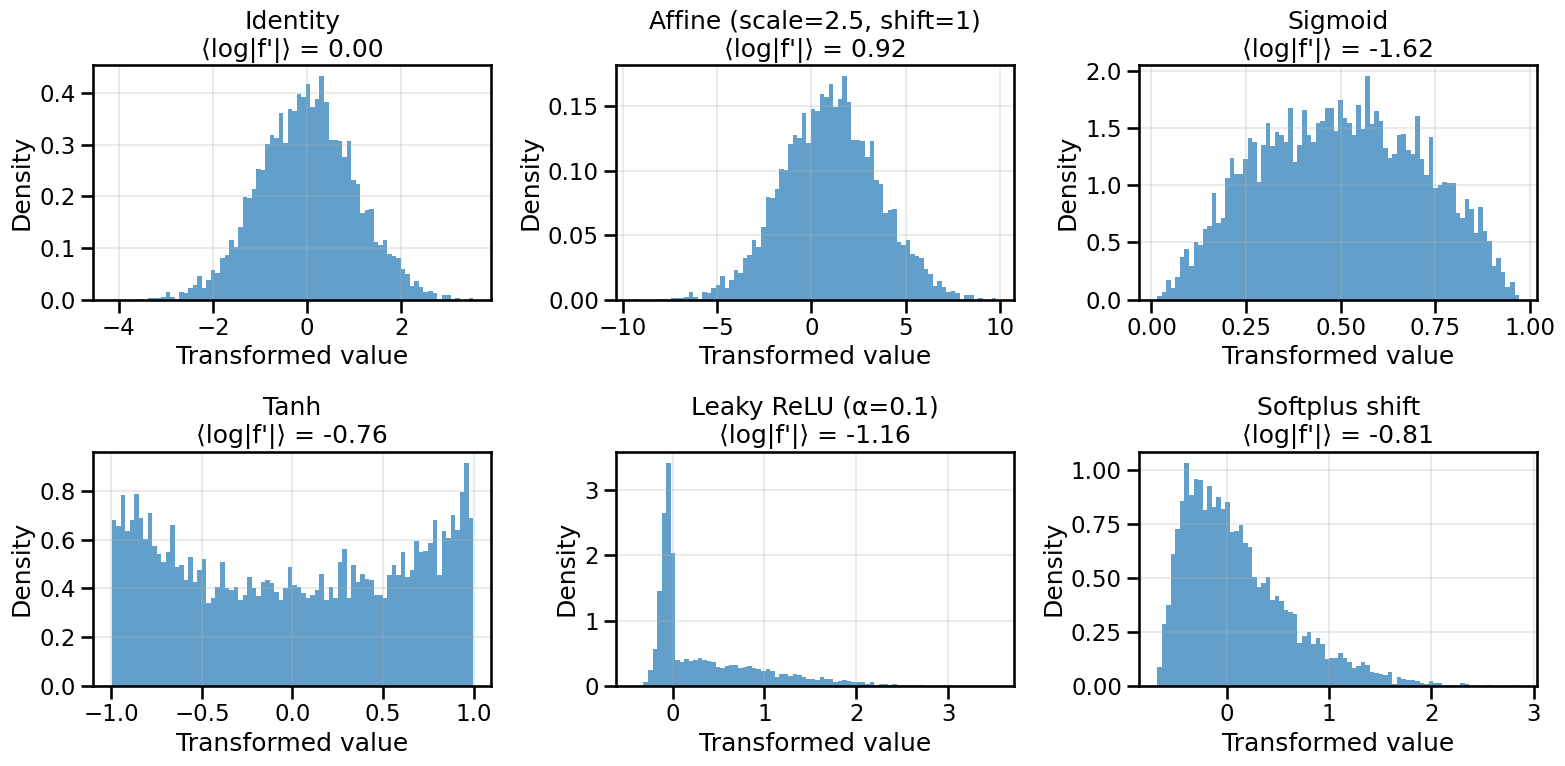

In [6]:
# Applying 1D transforms to a Gaussian base distribution
samples_1d = 6_000
base_1d = Normal(loc=torch.tensor(0.0, device=device), scale=torch.tensor(1.0, device=device))

def derivative(label: str, z: torch.Tensor) -> torch.Tensor:
    if label == "Identity":
        return torch.ones_like(z)
    if label.startswith("Affine"):
        return torch.full_like(z, 2.5)
    if label == "Sigmoid":
        s = torch.sigmoid(z)
        return s * (1 - s)
    if label == "Tanh":
        t = torch.tanh(z)
        return 1 - t.pow(2)
    if label.startswith("Leaky"):
        return torch.where(z >= 0, torch.ones_like(z), torch.full_like(z, 0.1))
    if label == "Softplus shift":
        return torch.sigmoid(z)
    raise ValueError(f"Unknown transform: {label}")

with torch.no_grad():
    z_samples = base_1d.sample((samples_1d,))
    transformed_samples = {}
    log_abs_det = {}
    for label, fn in transform_fns.items():
        y = fn(z_samples)
        transformed_samples[label] = y.cpu().numpy()
        jac = derivative(label, z_samples)
        log_abs_det[label] = torch.log(jac.abs() + 1e-8).cpu().numpy()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flat
for ax, (label, values) in zip(axes, transformed_samples.items()):
    ax.hist(values, bins=80, density=True, alpha=0.7, color='tab:blue')
    ax.set_title(f"{label}\n⟨log|f'|⟩ = {log_abs_det[label].mean():.2f}")
    ax.set_xlabel('Transformed value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

### More Complex Transforms

OK, so far so good, and the 1D change of variables is fairly intuitive. But how do we extend this to higher dimensions? For higher dimensions, the change-of-variables formula generalizes to:
$$
p_X(\mathbf{x}) = p_Z(f^{-1}(\mathbf{x})) \left\lvert \det \frac{\partial f^{-1}(\mathbf{x})}{\partial \mathbf{x}} \right\rvert = p_Z(\mathbf{z}) \left\lvert \det \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} \right\rvert^{-1}.
$$

where $\mathbf{x}, \mathbf{z} \in \mathbb{R}^D$ are now $D$-dimensional vectors, and the Jacobian (J) $\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}$ is a $D \times D$ matrix of partial derivatives:
$$
\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} = \begin{bmatrix}
\frac{\partial f_1(\mathbf{z})}{\partial z_1} & \frac{\partial f_1(\mathbf{z})}{\partial z_2} & \cdots & \frac{\partial f_1(\mathbf{z})}{\partial z_D} \\
\frac{\partial f_2(\mathbf{z})}{\partial z_1} & \frac{\partial f_2(\mathbf{z})}{\partial z_2} & \cdots & \frac{\partial f_2(\mathbf{z})}{\partial z_D} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_D(\mathbf{z})}{\partial z_1} & \frac{\partial f_D(\mathbf{z})}{\partial z_2} & \cdots & \frac{\partial f_D(\mathbf{z})}{\partial z_D}
\end{bmatrix}
$$

So, if we unpack the new formula, we see that the density at a point $\mathbf{x}$ depends on the density at the corresponding point $\mathbf{z} = f^{-1}(\mathbf{x})$ in the base distribution, scaled by the volume change induced by the transformation $f$ at that point, as captured by the **determinant of the Jacobian**. As such, in normalizing flows, most of the effort goes into designing transformations $f$ (or compositions of transformations) that are:

1. **Invertible**: So we can compute $f^{-1}(\mathbf{x})$.
2. **Tractable Jacobian Determinant**: So we can efficiently compute $\log|\det \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}}|$.
3. **Expressive**: So that the composition of multiple such transformations can model complex target distributions.

#### A Refresher on Determinants
Before going into specific transformations or architectures, let's briefly refresh our understanding of determinants, in general.[^1] We will see that many of the common transformations in Normalizing Flows are designed to take advantage of one or more of the following properties of determinants:

- **Product Rule**: For two square matrices $\mathbf{A}$ and $\mathbf{B}$ of the same size, $\det(\mathbf{A}\mathbf{B}) = \det(\mathbf{A}) \cdot \det(\mathbf{B})$. This means that for a composition of functions $f = f_2 \circ f_1$, the Jacobian determinant is the product of the individual determinants: $\det(J_f) = \det(J_{f_2}) \cdot \det(J_{f_1})$.
- **Matrix Inversion**: The determinant of the inverse of a matrix is the reciprocal of the determinant: $\det(\mathbf{A}^{-1}) = 1/\det(\mathbf{A})$. This is useful when computing the density of the transformed variable using the inverse transformation.
- **Eigenvalues**: The determinant of a matrix can also be computed as the product of its eigenvalues. This property is sometimes used in flow architectures that involve spectral methods or transformations based on eigen-decompositions.
- **Triangular Matrices**: The determinant of a triangular matrix (upper or lower) is simply the product of its diagonal elements: $\det J = \prod_{i=1}^d \frac{\partial f_i}{\partial x_i}$ and the log-determinant is just the sum of those diagonal terms. This property is often exploited in flow architectures to design transformations with triangular Jacobians, making the determinant computation efficient. This is because, for a matrix of size $D \times D$, computing the determinant directly is $O(D^3)$, while for triangular matrices this reduces to $O(D)$. We can see that a diagonal matrix is a special case of a triangular matrix, as thus has the same formula for the determinant.
- **Block Matrices**: For block diagonal matrices, the determinant is the product of the determinants of the blocks. This allows for designing transformations that operate on subsets of dimensions independently, simplifying the Jacobian structure.
- **Orthogonal Matrices**: For orthogonal matrices (where $\mathbf{A}^T\mathbf{A} = \mathbf{I}$), the determinant is either +1 or -1. This property is useful in designing volume-preserving transformations, since we can make sure that the determinant of the Jacobian is one, and thus simplify density computations or ensure that volume doesn't change. This is also useful in special matrices like Permutation matrices, which are orthogonal, and we will see later are useful for shuffling dimensions in coupling layers.
- **Volume Preserving Matrices**: Some transformations are designed to be volume-preserving, meaning that they do not change the volume of regions in space. For such transformations, the determinant of the Jacobian is one. These will have important analogues to continuous flows which we will see in later noterbooks, where this property corresponds to divergence-free vector fields ($\nabla \cdot f = 0$).
- **Low-Rank Updates**: For matrices that can be expressed as a low-rank update to another matrix, the determinant can be computed using the [matrix determinant lemma](https://en.wikipedia.org/wiki/Matrix_determinant_lemma). This is particularly useful in certain flow architectures that involve low-rank transformations, such as planar flows. Specifically, if $\mathbf{A}$ is an invertible matrix and $\mathbf{u}, \mathbf{v}$ are column vectors, then: $\det(\mathbf{A} + \mathbf{u}\mathbf{v}^T) = \det(\mathbf{A}) \cdot (1 + \mathbf{v}^T \mathbf{A}^{-1} \mathbf{u})$. In the special case where $\mathbf{A}$ is the identity matrix, this simplifies to: $\det(\mathbf{I} + \mathbf{u}\mathbf{v}^T) = 1 + \mathbf{v}^T \mathbf{u}$.

With these properties in mind, we can now explore some common transformations used in normalizing flows.

[^1]: For some common matrix identities, I can recommend reviewing the [Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

#### Affine Transforms
These are the simplest layers, applying a linear transformation followed by a shift: $f(\mathbf{z}) = \mathbf{A}\mathbf{z} + \mathbf{b}$. The Jacobian is simply $\mathbf{A}$, so its log-determinant is $\log|\det \mathbf{A}|$. If $\mathbf{A}$ is a rotation matrix, the transform is volume-preserving ($\log|\det|=0$). If $\mathbf{A}$ is diagonal, it applies axis-aligned scaling.


#### Planar Flows
These layers stretch and compress the space along a specific direction (a hyperplane). The transformation is $f(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$, where $\mathbf{u}, \mathbf{w}$ are vectors, $b$ is a scalar, and $h$ is a smooth nonlinearity like $\tanh$. This creates contractions or expansions perpendicular to the hyperplane $\mathbf{w}^T\mathbf{z} + b=0$. Because this is a low-rank update, the log-determinant can be efficiently computed as $\log|1 + \mathbf{u}^T\mathbf{v}(\mathbf{z})|$, where $\mathbf{v}(\mathbf{z}) = h'(\mathbf{w}^T\mathbf{z}+b)\mathbf{w}$.


#### Radial Flows
These layers modify the space around a reference point $\mathbf{z}_0$: $f(\mathbf{z}) = \mathbf{z} + \beta \frac{\mathbf{z}-\mathbf{z}_0}{\alpha+r}$, where $r=||\mathbf{z}-\mathbf{z}_0||$ is a radius from the reference point and $\alpha > 0, \beta \in \R$ are fixed or learned scalars parameterizing the function. This can create or fill holes in the distribution around $\mathbf{z}_0$ by pushing or pulling points in $\mathbf{z}$ toward/away from $\mathbf{z}_0$. Its Jacobian is given by:
$$
\frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} = \mathbf{I} + h(r)\mathbf{I} + h'(r) \frac{(\mathbf{z}-\mathbf{z}_0)(\mathbf{z}-\mathbf{z}_0)^T}{r}
$$  

where $h(r) = \frac{\beta}{\alpha + r}$ and $h'(r) = -\frac{\beta}{(\alpha + r)^2}$. As in planar flows, this is a low-rank update, so we can use the matrix determinant lemma to compute the determinant efficiently:
$$
\det \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} = (1 + h(r))^{D-1} (1 + h(r) + h'(r) r) = \left(1 + \frac{\beta}{\alpha + r}\right)^{D-1} \left(1 + \frac{\beta \alpha}{(\alpha + r)^2}\right)
$$

#### Affine Coupling Layers
We are not only restricted to transforming the entire base distribution in one function. We can also split the base distribution into two parts, $\mathbf{z}_1$ and $\mathbf{z}_2$. One part is used to parameterize an affine transformation on the other:

$$
\begin{aligned}
\mathbf{y}_1 &= \mathbf{z}_1 \\
\mathbf{y}_2 &= \mathbf{z}_2 \odot \exp(s(\mathbf{z}_1)) + t(\mathbf{z}_1)
\end{aligned}
$$

Here, $s$ (scale) and $t$ (translate) are neural networks. Let's assume for this simple example that $\mathbf{z}_1$ and $\mathbf{z}_2$ are each half of the dimensions of $\mathbf{z}$. The inverse transformation is straightforward:
$$
\begin{aligned}
\mathbf{z}_1 &= \mathbf{y}_1 \\
\mathbf{z}_2 &= (\mathbf{y}_2 - t(\mathbf{y}_1)) \odot \exp(-s(\mathbf{y}_1))
\end{aligned}
$$

We can also see that this approach endowed the Jacobian with a triangular structure:
$$
\frac{\partial \mathbf{y}}{\partial \mathbf{z}} = \begin{bmatrix}
\mathbf{I} & \mathbf{0} \\
\frac{\partial \mathbf{y}_2}{\partial \mathbf{z}_1} & \text{diag}(\exp(s(\mathbf{z}_1)))
\end{bmatrix}
$$

Since the Jacobian is triangular, this makes its determinant just the product of the diagonal elements: $\sum_j s(\mathbf{z}_1)_j$. This is expressive, efficient, and easily invertible. Of course the cost of doing this is that we can only transform half of the dimensions in one layer, leaving the rest unchanged. To address this, we can stack multiple coupling layers, alternating which half of the dimensions are transformed in each layer. Additionally, we can add permutation layers (which are orthogonal and volume-preserving) between coupling layers to shuffle the dimensions, ensuring that all dimensions get transformed over multiple layers.

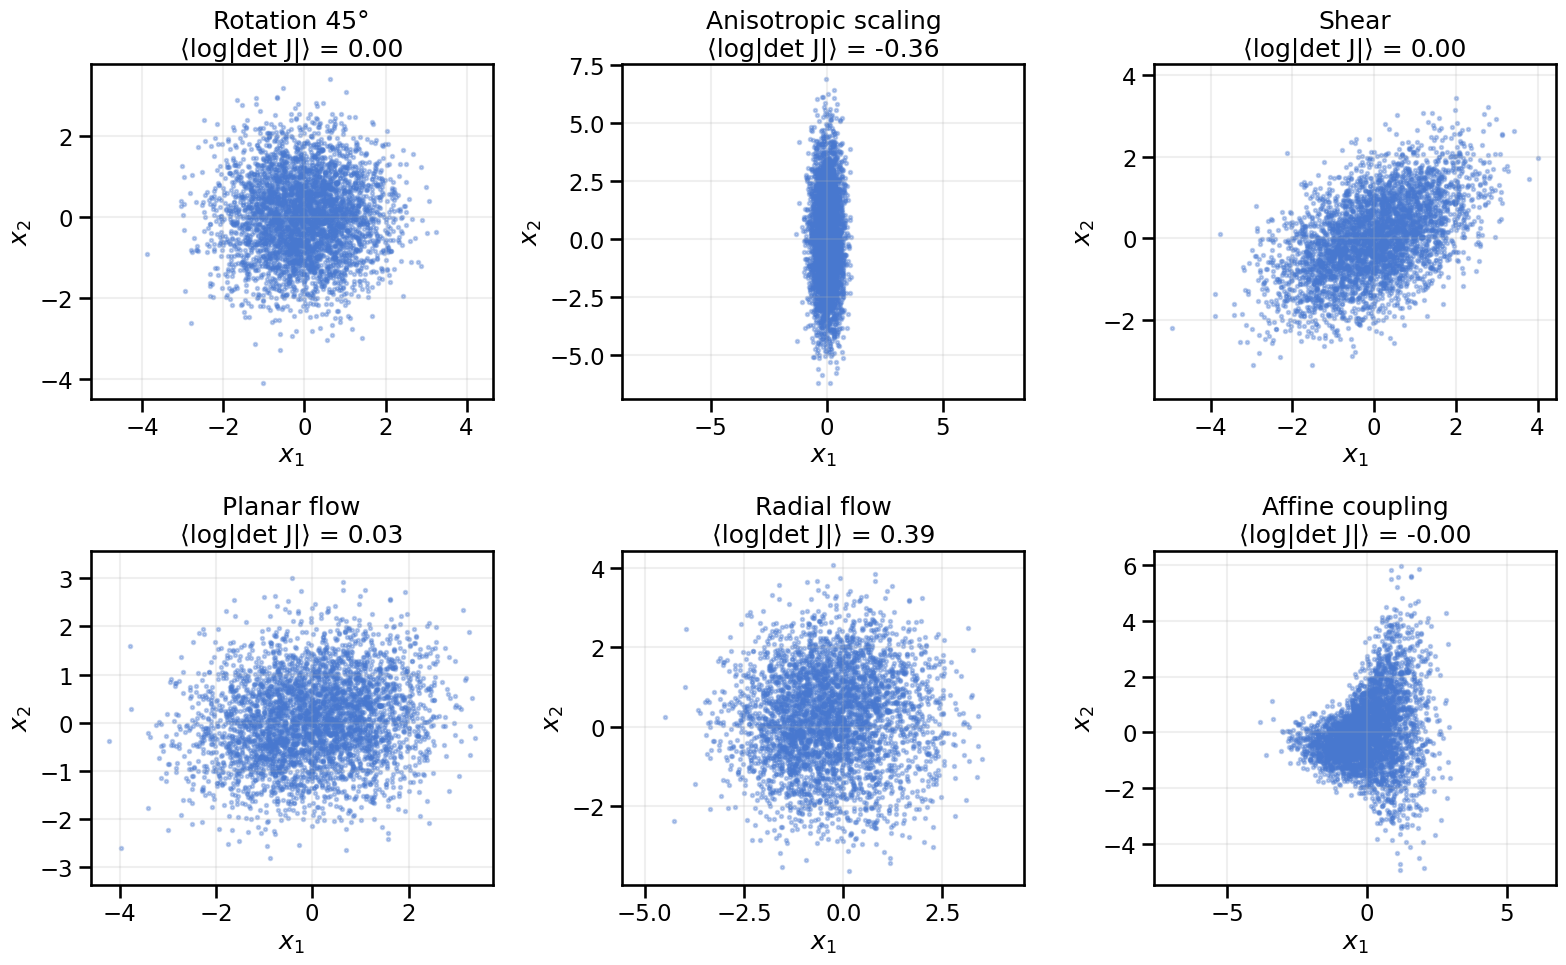

In [7]:
# Exploring 2D invertible transforms that inspire flow layers
samples_2d = 4_000
base_2d = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2))

with torch.no_grad():
    z2 = base_2d.sample((samples_2d,))

    rotation = torch.tensor([[np.cos(np.deg2rad(45.0)), -np.sin(np.deg2rad(45.0))],
                               [np.sin(np.deg2rad(45.0)), np.cos(np.deg2rad(45.0))]], dtype=torch.float32)
    scale = torch.tensor([[0.35, 0.0],[0.0, 2.0]], dtype=torch.float32)
    shear = torch.tensor([[1.0, 0.6],[0.0, 1.0]], dtype=torch.float32)

    w = torch.tensor([0.6, -0.4])
    u = torch.tensor([0.4, 0.5])
    b = torch.tensor(0.1)

    z0 = torch.tensor([1.2, -0.8])
    alpha = torch.tensor(1.0)
    beta = torch.tensor(0.8)

    def planar_flow(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        linear = x @ w + b
        h = torch.tanh(linear)
        psi = (1 - torch.tanh(linear).pow(2)).unsqueeze(-1) * w
        det_term = 1 + (psi * u).sum(dim=1)
        y = x + u * h.unsqueeze(-1)
        return y, det_term

    def radial_flow(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        diff = x - z0
        r = diff.norm(dim=1, keepdim=True) + 1e-6
        h = 1.0 / (alpha + r)
        h_prime = -1.0 / (alpha + r).pow(2)
        y = x + beta * h * diff
        det_term = (1 + beta * h.squeeze()) * (1 + beta * h.squeeze() + beta * h_prime.squeeze() * r.squeeze())
        return y, det_term

    def affine_coupling(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x1 = x[:, :1]
        x2 = x[:, 1:]
        s = 0.75 * torch.tanh(x1)
        t = 0.5 * torch.sin(x1)
        y1 = x1
        y2 = x2 * torch.exp(s) + t
        y = torch.cat([y1, y2], dim=1)
        det_term = torch.exp(s.squeeze())
        return y, det_term

    transforms_2d = {}
    log_abs_det_2d = {}

    y_rot = z2 @ rotation.T
    transforms_2d["Rotation 45°"] = y_rot.numpy()
    log_abs_det_2d["Rotation 45°"] = np.zeros(samples_2d)

    y_scale = z2 @ scale.T
    transforms_2d["Anisotropic scaling"] = y_scale.numpy()
    log_abs_det_2d["Anisotropic scaling"] = np.full(samples_2d, np.log(abs(torch.det(scale).item())))

    y_shear = z2 @ shear.T
    transforms_2d["Shear"] = y_shear.numpy()
    log_abs_det_2d["Shear"] = np.zeros(samples_2d)

    y_planar, det_planar = planar_flow(z2)
    transforms_2d["Planar flow"] = y_planar.numpy()
    log_abs_det_2d["Planar flow"] = torch.log(det_planar.abs() + 1e-8).numpy()

    y_radial, det_radial = radial_flow(z2)
    transforms_2d["Radial flow"] = y_radial.numpy()
    log_abs_det_2d["Radial flow"] = torch.log(det_radial.abs() + 1e-8).numpy()

    y_coupling, det_coupling = affine_coupling(z2)
    transforms_2d["Affine coupling"] = y_coupling.numpy()
    log_abs_det_2d["Affine coupling"] = torch.log(det_coupling.abs() + 1e-8).numpy()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flat
for ax, (label, points) in zip(axes, transforms_2d.items()):
    ax.scatter(points[:, 0], points[:, 1], s=6, alpha=0.35)
    ax.set_title(f"{label}\n⟨log|det J|⟩ = {log_abs_det_2d[label].mean():.2f}")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('equal')
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

### From Transforms to Complex Flows and Probabilities

In practice, we can stack many such layers of different types to build a deep normalizing flow that can model complex target distributions. Each layer contributes to the overall transformation, and we can compute the log-density of the transformed variable by summing the log-determinants of each layer's Jacobian. Each transform above comes with a Jacobian determinant that tells us how probability mass re-scales. In one dimension, the recipe is
$$
\log p_Y(y) = \log p_Z(f^{-1}(y)) + \log\left|\frac{\mathrm{d} f^{-1}(y)}{\mathrm{d} y}\right| = \log p_Z(z) - \log\left|f'(z)\right|.
$$
For multivariate flows with $x = f(z)$, we track the log-determinant at every layer:
$$
\log p_X(x) = \log p_Z(z_0) + \sum_{\ell=1}^K \log\left|\det J_{f_\ell}(z_{\ell-1})\right|,
$$
\Computing these terms is why we prefer architectures (like affine coupling, planar, or radial flows) with Jacobians that are either triangular or have closed-form determinants, so that we can avoid very expensive determinant calculations. When training a flow we maximise this exact log-likelihood, and during sampling we simply draw $z \sim p_Z$ and apply the inverses $f_\ell^{-1}$ in reverse order.

## Constructing a Flow with Coupling Layers using RealNVP

One of the first models for building tractable flows was the RealNVP (Real-valued Non-Volume Preserving) architecture. It splits the vector into two parts, using a coupling layer as we saw previously. This leaves one part unchanged, and uses it to condition an affine transformation on the other part. Because the transformation is triangular, the Jacobian determinant is the product of diagonal entries and is therefore easy to compute. Below implements a RealNVP flow using coupling layers where we swap in each layer which one of the two input dimensions is fixed. For a larger or more complex example with more inputs, these could be selected randomly using permutations, but our simple approach below is just to illustrate the concept.

In [8]:
#| code-fold: false
class AffineCoupling(nn.Module):
    """RealNVP-style affine coupling layer for 2D inputs."""
    def __init__(self, dim: int, hidden_dim: int, mask: torch.Tensor):
        super().__init__()
        self.dim = dim
        self.register_buffer('mask', mask)
        self.scale_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        self.translate_net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        nn.init.zeros_(self.scale_net[-1].weight)
        nn.init.zeros_(self.scale_net[-1].bias)
        nn.init.zeros_(self.translate_net[-1].weight)
        nn.init.zeros_(self.translate_net[-1].bias)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        s = torch.tanh(s)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = ((1 - self.mask) * s).sum(dim=1)
        return y, log_det

    def inverse(self, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        s = torch.tanh(s)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det = -((1 - self.mask) * s).sum(dim=1)
        return x, log_det


class RealNVP(nn.Module):
    """Stack of affine coupling layers implementing a normalizing flow."""
    def __init__(self, dim: int = 2, hidden_dim: int = 128, n_layers: int = 6):
        super().__init__()
        masks: List[torch.Tensor] = []
        for i in range(n_layers):
            if i % 2 == 0:
                mask = torch.tensor([1.0, 0.0])
            else:
                mask = torch.tensor([0.0, 1.0])
            masks.append(mask)
        self.layers = nn.ModuleList([
            AffineCoupling(dim=dim, hidden_dim=hidden_dim, mask=mask)
            for mask in masks
        ])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        log_det_total = torch.zeros(x.shape[0], device=x.device)
        z = x
        for layer in self.layers:
            z, log_det = layer(z)
            # Note here how we can just accumulate log-determinants forward:
            log_det_total = log_det_total + log_det
        return z, log_det_total

    def inverse(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        log_det_total = torch.zeros(z.shape[0], device=z.device)
        x = z
        for layer in reversed(self.layers):
            x, log_det = layer.inverse(x)
            # Likewise, here we can accumulate log-determinants backward:
            log_det_total = log_det_total + log_det
        return x, log_det_total

    def inverse_with_intermediates(self, z: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, List[torch.Tensor]]:
        """Inverse transformation that also returns intermediate layer outputs."""
        log_det_total = torch.zeros(z.shape[0], device=z.device)
        x = z
        intermediates = [z.clone()]
        for layer in reversed(self.layers):
            x, log_det = layer.inverse(x)
            log_det_total = log_det_total + log_det
            intermediates.append(x.clone())
        return x, log_det_total, intermediates

    def log_prob(self, x: torch.Tensor, base_dist: MultivariateNormal) -> torch.Tensor:
        z, log_det = self.forward(x)
        log_prob_base = base_dist.log_prob(z)
        # Now we can just combine base log-probability and log-determinant, which we accumulated earlier
        return log_prob_base + log_det

    def sample(self, num_samples: int, base_dist: MultivariateNormal) -> torch.Tensor:
        with torch.no_grad():
            z = base_dist.sample((num_samples,))
            x, _ = self.inverse(z)
        return x

### Training a Flow on the Ring-of-Gaussians Dataset

We now train a small RealNVP model on the same ring dataset used in the VAE notebook. Unlike the VAE, the flow optimizes the exact log-likelihood of the data, so we do not need a separate encoder or a variational bound. The key ingredients are:

1. A base density $p_0(z)$ (we use a standard 2D Gaussian).
2. A flow $f_{\theta}$ composed of coupling layers.
3. An optimizer to maximize $\log p_X(x) = \log p_0(f(x)) + \log \lvert \det J_f(x) \rvert$.

In [9]:
#| code-fold: false
@dataclass
class FlowHistory:
    loss: List[float]
    log_prob: List[float]
    diversity: List[float]


def train_flow_model(
    data: np.ndarray,
    flow: RealNVP,
    base_dist: MultivariateNormal,
    epochs: int = 300,
    batch_size: int = 256,
    lr: float = 1e-3,
    print_every: int = 50
) -> Tuple[RealNVP, FlowHistory]:
    flow.train()
    loader = make_loader(data, batch_size)
    optimizer = optim.Adam(flow.parameters(), lr=lr)
    history = FlowHistory(loss=[], log_prob=[], diversity=[])

    for epoch in range(epochs):
        batch_losses = []
        batch_log_probs = []
        for (batch,) in loader:
            batch = batch.float().to(device)
            log_prob = flow.log_prob(batch, base_dist)
            loss = -log_prob.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            batch_log_probs.append(log_prob.mean().item())

        mean_loss = float(np.mean(batch_losses))
        mean_log_prob = float(np.mean(batch_log_probs))

        with torch.no_grad():
            samples = flow.sample(2048, base_dist)
            diversity = compute_diversity_metric(samples)

        history.loss.append(mean_loss)
        history.log_prob.append(mean_log_prob)
        history.diversity.append(diversity)

        if (epoch + 1) % print_every == 0 or epoch == 1:
            print(f'Epoch {epoch + 1:03d}/{epochs} | Loss: {mean_loss:.3f} | Log p(x): {mean_log_prob:.3f} | Div: {diversity:.3f}')

    flow.eval()
    return flow, history

X_ring, y_ring = create_ring_gaussians(n_samples=2000)

You can modify the below RealNVP parameters (number of layers, hidden units) and retrain the flow to see how it affects expressiveness and training time, as we mention for the experiment at the end of the notebook.

In [10]:
#| code-fold: false
# Train the flow on the ring dataset
flow = RealNVP(dim=2, hidden_dim=128, n_layers=6).to(device)
base_dist = MultivariateNormal(
    loc=torch.zeros(2, device=device),
    covariance_matrix=torch.eye(2, device=device)
)
flow, flow_history = train_flow_model(
    data=X_ring,
    flow=flow,
    base_dist=base_dist,
    epochs=300,
    batch_size=256,
    lr=1e-3,
    print_every=50
)

Epoch 002/300 | Loss: 4.634 | Log p(x): -4.634 | Div: 15.833
Epoch 050/300 | Loss: 2.800 | Log p(x): -2.800 | Div: 4.141
Epoch 100/300 | Loss: 2.591 | Log p(x): -2.591 | Div: 4.106
Epoch 150/300 | Loss: 2.430 | Log p(x): -2.430 | Div: 4.275
Epoch 200/300 | Loss: 2.490 | Log p(x): -2.490 | Div: 4.298
Epoch 250/300 | Loss: 2.383 | Log p(x): -2.383 | Div: 4.308
Epoch 300/300 | Loss: 2.401 | Log p(x): -2.401 | Div: 4.274


### Monitoring Training Dynamics

The total loss is the negative log-likelihood (NLL). Because we optimize the exact density, improvements in the loss correspond directly to better calibrated probabilities. We also track a simple diversity statistic computed from generated samples to monitor coverage.

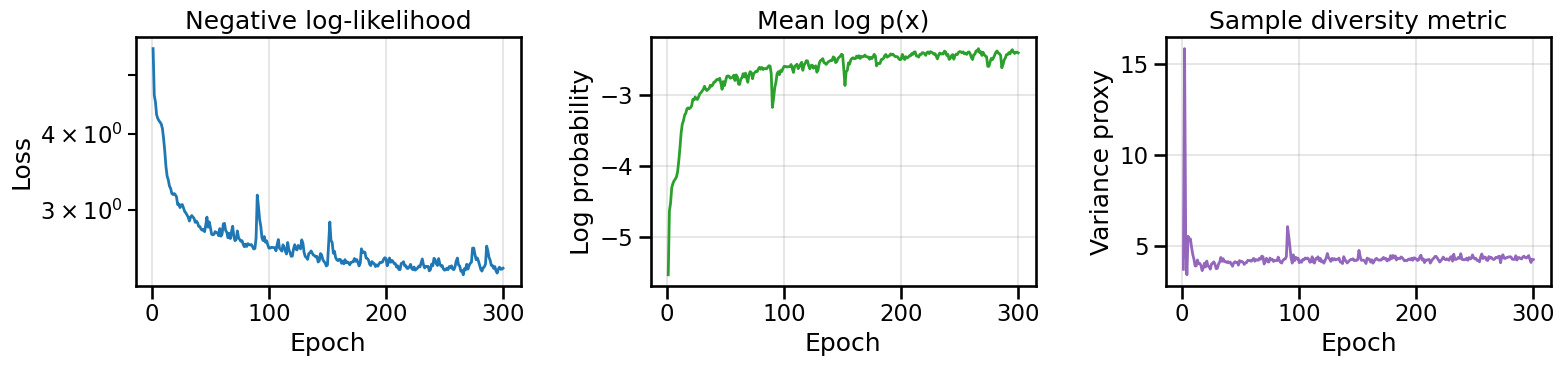

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
epochs_axis = np.arange(1, len(flow_history.loss) + 1)

axes[0].plot(epochs_axis, flow_history.loss, color='tab:blue', linewidth=2)
axes[0].set_title('Negative log-likelihood')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_axis, flow_history.log_prob, color='tab:green', linewidth=2)
axes[1].set_title('Mean log p(x)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Log probability')
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs_axis, flow_history.diversity, color='tab:purple', linewidth=2)
axes[2].set_title('Sample diversity metric')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Variance proxy')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Inspecting the Learned Mapping

With a trained flow we can examine three complementary views: the data space, the latent space obtained by applying the forward transformation $f(x)$, and samples generated by pushing base noise through the inverse transformation $f^{-1}(z)$. A well-trained flow should map the multimodal ring distribution onto a near-Gaussian latent distribution while recovering the ring geometry when sampling.

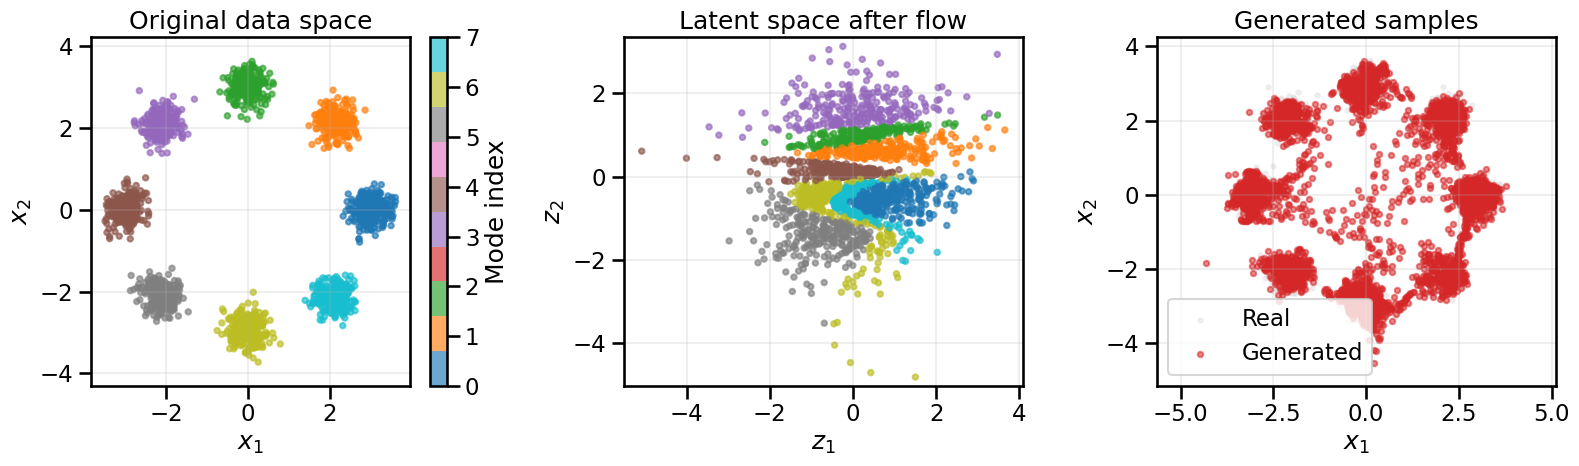

In [12]:
flow.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_ring).float().to(device)
    z_encoded, _ = flow.forward(X_tensor)
    z_encoded = z_encoded.cpu().numpy()
    generated = flow.sample(4000, base_dist).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sc0 = axes[0].scatter(X_ring[:, 0], X_ring[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.65)
axes[0].set_title('Original data space')
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.2)
plt.colorbar(sc0, ax=axes[0], label='Mode index')

axes[1].scatter(z_encoded[:, 0], z_encoded[:, 1], c=y_ring, cmap='tab10', s=15, alpha=0.65)
axes[1].set_title('Latent space after flow')
axes[1].set_xlabel('$z_1$')
axes[1].set_ylabel('$z_2$')
axes[1].axis('equal')
axes[1].grid(True, alpha=0.2)

axes[2].scatter(X_ring[:, 0], X_ring[:, 1], c='lightgray', s=10, alpha=0.3, label='Real')
axes[2].scatter(generated[:, 0], generated[:, 1], c='tab:red', s=15, alpha=0.55, label='Generated')
axes[2].set_title('Generated samples')
axes[2].set_xlabel('$x_1$')
axes[2].set_ylabel('$x_2$')
axes[2].axis('equal')
axes[2].grid(True, alpha=0.2)
axes[2].legend()

plt.tight_layout()
plt.show()

### Layer-by-Layer Transformation

To better understand how the normalizing flow works, let's visualize how each coupling layer progressively transforms the base distribution into the target distribution. We'll sample from the base Gaussian and then apply each layer's inverse transformation one at a time, coloring the points by their eventual mode assignment (determined by which ring Gaussian they end up closest to).

This visualization shows the geometric action of each layer, illustrating how the flow gradually warps the simple base distribution into the complex ring structure. Note in particular how the RealNVP coupling layers show up here: in the first layer only one of the dimensions is changed, while the other remains fixed. In the next layer, the roles are swapped, and so on.

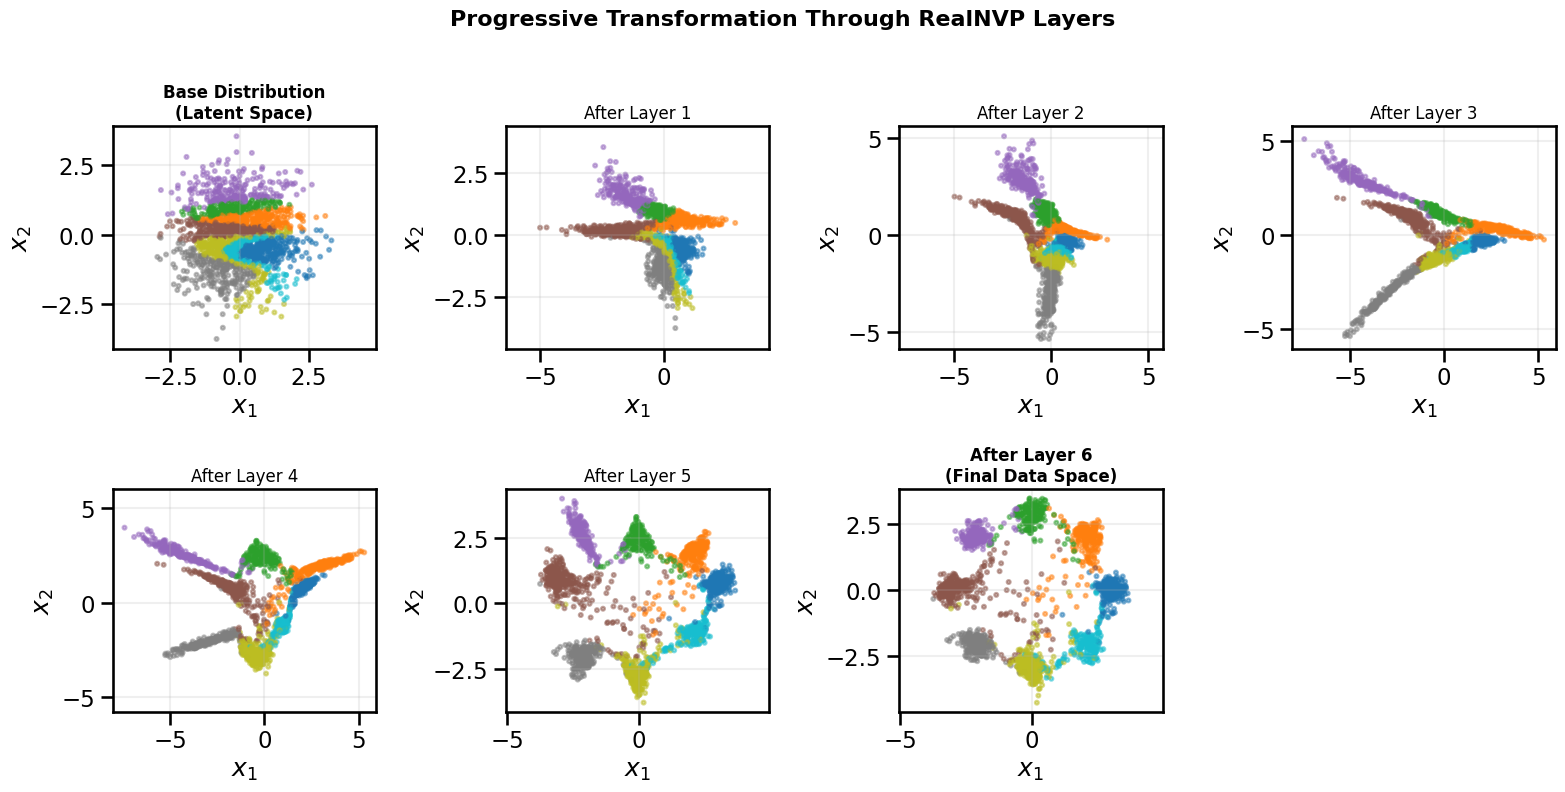

In [13]:
# Visualize how each layer transforms the distribution
flow.eval()
with torch.no_grad():
    # Sample from base distribution
    z_base = base_dist.sample((2000,))
    
    # Get intermediate transformations
    x_final, _, intermediates = flow.inverse_with_intermediates(z_base)
    
    # Also encode the real data to get mode labels for coloring
    X_tensor = torch.from_numpy(X_ring).float().to(device)
    z_real, _ = flow.forward(X_tensor)
    
    # For each base sample, find the closest real data point to determine its "mode"
    # This is a simple nearest-neighbor approach for visualization
    from scipy.spatial.distance import cdist
    distances = cdist(z_base.cpu().numpy(), z_real.cpu().numpy())
    nearest_indices = distances.argmin(axis=1)
    colors = y_ring[nearest_indices]

# Create a grid of subplots
n_layers = len(intermediates)
n_cols = 4
n_rows = (n_layers + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, intermediate in enumerate(intermediates):
    ax = axes[i]
    points = intermediate.cpu().numpy()
    ax.scatter(points[:, 0], points[:, 1], c=colors, cmap='tab10', s=8, alpha=0.5)
    
    if i == 0:
        ax.set_title('Base Distribution\n(Latent Space)', fontsize=12, fontweight='bold')
    elif i == len(intermediates) - 1:
        ax.set_title(f'After Layer {i}\n(Final Data Space)', fontsize=12, fontweight='bold')
    else:
        ax.set_title(f'After Layer {i}', fontsize=12)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.axis('equal')
    ax.grid(True, alpha=0.2)

# Hide any unused subplots
for i in range(n_layers, len(axes)):
    axes[i].axis('off')

plt.suptitle('Progressive Transformation Through RealNVP Layers', fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

::: {.callout-tip appearance="default"}
### Experiment: Effect of Flow Depth and Width

Go back up to where we defined the RealNVP architecture and try it again with the following changes and note the behavior that you see:

- Vary the number of coupling layers (e.g., 2, 4, 8, 16). What happens to the quality of the learned distribution and the training time?
- What does varying the number of hidden units in the scale and translate networks do to the expressiveness and stability of training?
- As you make the number of coupling layers extremely large (50,100), what do you notice about the training dynamics as well as the effect of individual layers on the movement of the distribution?

:::

## Advantages and Limitations of Normalizing Flows

| Strengths | Limitations |
|-----------|-------------|
| Exact log-likelihood evaluation enables principled model comparison | Computing Jacobians can be expensive for high-dimensional data |
| Invertible architecture provides bidirectional mapping without a separate encoder | Designing expressive yet tractable transforms is challenging |
| Amenable to gradient-based training with standard optimizers | Coupling layers may struggle with highly non-local dependencies |
| Samples are sharp because no explicit reconstruction loss is used | Memory footprint grows with the number of layers |

Normalizing flows shine when calibrated densities and invertible mappings are required, such as uncertainty-aware control or anomaly detection in sensor networks. However, they can become cumbersome in very high dimensions or when local affine transformations are insufficient.

## Summary and Looking Ahead

- Normalizing flows learn an exact, differentiable transformation between a base distribution and the data, turning density modeling into a sequence of Jacobian adjustments.
- The change-of-variables formula provides the theoretical backbone, allowing us to evaluate log-likelihoods exactly.
- Coupling layers (as in RealNVP) offer an efficient way to construct expressive flows with tractable inverses and determinants.
- On the ring dataset, flows match the multimodal structure while keeping a simple latent Gaussian distribution.

If you ran the last experiment, you may have noticed that as we increase the number of layers, the individual transformations become smaller and more incremental. What would happen if we set the number of layers to infinity? In this case, each individual transformation would become an almost infinitesimal transformation from one probability distribution to another, and the integral over all of those many transformations would get us the flow from $z$ to $x$. This is exactly the idea behind *continuous normalizing flows* or neural ODE-based flows, where the model evolves samples through a learned vector field. Introducing stochastic dynamics yields *stochastic flows* that blend diffusion models with flow-based ideas. These extensions retain the change-of-variables logic while trading discrete layers for continuous-time dynamics, setting the stage for the next chapter.

